## Part A: Predictive Modeling with ‘DataScientist_01_Assessment’ Data- 25 Points

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import shap
from pathlib import Path
from joblib import load
import warnings
from pathlib import Path

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 12, 'axes.titlesize': 12, 'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12})


In [4]:
base_path = Path("..").resolve()
data_path = base_path / "Data" / "DataScientist_01_Assessment.csv"
df = pd.read_csv(data_path)


In [ ]:
# Cleaning and Standardizing
for col in df.select_dtypes(include='object').columns:
    df[col] = (df[col].astype(str).str.strip() .str.lower().str.replace(r'[\s\+\/\-\.\|]+', '_', regex=True))
df.columns = (df.columns.str.strip().str.lower().str.replace(r'[\s\+\/\-\.\|]+', '_', regex=True))
df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

# df.columns

In [ ]:
# the target label function
def progress_status(val):
    if val >= 2.15:
        return "On Track"
    elif val >= 1.77:
        return "At Risk"
    elif val >= 1.25:
        return "Struggling"
    else:
        return "Severely Struggling"

df['ProgressStatus'] = df['hhincome_consumption_residues_day'].apply(progress_status)
status_map = {"Severely Struggling": 0, "Struggling": 1, "At Risk": 2, "On Track": 3}
df['target'] = df['ProgressStatus'].map(status_map)


In [ ]:
# Features and target
columns_to_exclude = ['progressstatus', 'target', 'householdid', 'hhincome_consumption_residues_day']
X = df.drop(columns=columns_to_exclude, errors='ignore') 
y = df['target']

# One-hot encoding of categorical variables
X = pd.get_dummies(X, drop_first=True)

# Fills missing numeric values with median
X.fillna(X.median(), inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, test_size=0.2, random_state=42 )

# multinomial logistic regression
model = make_pipeline( StandardScaler(), LogisticRegression( multi_class='multinomial', solver='lbfgs', max_iter=5000, random_state=42 ) )
model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=5000, multi_class='multinomial',
                                    random_state=42))])

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)


In [ ]:
# Evaluation report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=status_map.keys()))


Classification Report:
                     precision    recall  f1-score   support

Severely Struggling       1.00      1.00      1.00       152
         Struggling       1.00      1.00      1.00       180
            At Risk       1.00      1.00      1.00       107
           On Track       1.00      1.00      1.00       341

           accuracy                           1.00       780
          macro avg       1.00      1.00      1.00       780
       weighted avg       1.00      1.00      1.00       780



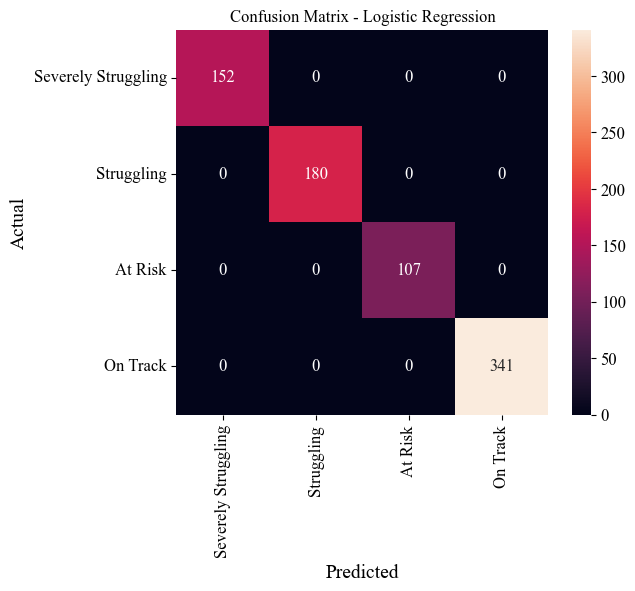

In [ ]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=status_map.keys(), yticklabels=status_map.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### ●	Which features most significantly influence the model's prediction of a household being “At Risk” or “Struggling,” and how were these identified during model building?

In [ ]:
# correct rows in coef_
class_indices = {v: i for i, v in enumerate(status_map.keys())}

# coefficients for 'At Risk' and 'Struggling'
coef_df = pd.DataFrame( model.named_steps['logisticregression'].coef_, columns=X.columns, index=status_map.keys() ).T

# coefficients for relevant classes
at_risk_coefs = coef_df['At Risk'].sort_values(key=abs, ascending=False)
struggling_coefs = coef_df['Struggling'].sort_values(key=abs, ascending=False)

print("Top features influencing 'At Risk' prediction:")
print(at_risk_coefs.head(10))

print("\nTop features influencing 'Struggling' prediction:")
print(struggling_coefs.head(10))


Top features influencing 'At Risk' prediction:
ProgressStatus_On Track              -2.613977
ProgressStatus_Struggling            -2.057470
ProgressStatus_Severely Struggling   -1.571274
hhincome_consumption_residues         0.148159
agricvalue                            0.132949
casuallabour                          0.129073
householdicome                        0.117203
hhincome_day                          0.117203
consumption_day                       0.110430
consumption_residues                  0.110430
Name: At Risk, dtype: float64

Top features influencing 'Struggling' prediction:
ProgressStatus_Struggling                   2.888776
ProgressStatus_Severely Struggling         -0.449516
hhincome_consumption_residues              -0.249953
householdicome                             -0.218199
hhincome_day                               -0.218199
ProgressStatus_On Track                    -0.204538
hhincome_consumption_assets_residues_day   -0.191093
hhincome_consumption_assets_res

In [ ]:
#df.columns

### ●	Are the model explanations consistent across sub-regions, gender groups, or household sizes?

In [ ]:
log_reg = model.named_steps['logisticregression']
coef_matrix = log_reg.coef_  

feature_names = X.columns

# Map class index to class name (use your actual status_map keys)
class_names = list(status_map.values())
coef_df = pd.DataFrame(coef_matrix.T, index=feature_names, columns=class_names)
subgroup_prefixes = ['district', 'hhh_sex', 'householdsize']

# Filter subgroup features
subgroup_features = [feat for feat in feature_names if any(feat.startswith(pref) for pref in subgroup_prefixes)]
subgroup_coefs = coef_df.loc[subgroup_features]

# Display subgroup coefficients for each class
print("Logistic Regression Coefficients for Subgroup Features (by class):")
print(subgroup_coefs)

for subgroup in subgroup_prefixes:
    print(f"\nCoefficients for features starting with '{subgroup}':\n")
    print(subgroup_coefs.loc[subgroup_coefs.index.str.startswith(subgroup)].sort_values(by=class_names[1], key=abs, ascending=False))


Logistic Regression Coefficients for Subgroup Features (by class):
                           0         1         2         3
householdsize      -0.009703  0.003458  0.002618  0.003626
hhh_sex             0.020017 -0.017259  0.002774 -0.005532
district_mitooma    0.014461  0.008921 -0.026023  0.002641
district_rubanda    0.053460 -0.008850 -0.017218 -0.027392
district_rukungiri  0.007526  0.027417 -0.005285 -0.029657

Coefficients for features starting with 'district':

                           0         1         2         3
district_rukungiri  0.007526  0.027417 -0.005285 -0.029657
district_mitooma    0.014461  0.008921 -0.026023  0.002641
district_rubanda    0.053460 -0.008850 -0.017218 -0.027392

Coefficients for features starting with 'hhh_sex':

                0         1         2         3
hhh_sex  0.020017 -0.017259  0.002774 -0.005532

Coefficients for features starting with 'householdsize':

                      0         1         2         3
householdsize -0.009703  0.

### ●	How does the model treat borderline cases (e.g., predicted ProgressStatus near the cutoff between “At Risk” and “Struggling”)?

In [ ]:
print("Model classes:", model.classes_)
#status_map = {"Severely Struggling": 0, "Struggling": 1, "At Risk": 2, "On Track": 3}

Model classes: [0 1 2 3]


In [ ]:
probs = model.predict_proba(X_test) 
at_risk_idx = np.where(model.classes_ == 2)[0][0] # At Risk
struggling_idx = np.where(model.classes_ == 1)[0][0] # Struggling


In [ ]:
prob_diff = np.abs(probs[:, at_risk_idx] - probs[:, struggling_idx])

#a threshold for borderline cases e.g., prob difference < 0.1 means close probabilities
threshold = 0.1
borderline_mask = prob_diff < threshold

# 5. Extract borderline cases' data
borderline_X = X_test[borderline_mask]
borderline_probs = probs[borderline_mask]
borderline_true = y_test[borderline_mask]

print(f"Number of borderline cases between 'At Risk' and 'Struggling': {borderline_X.shape[0]}")

# predicted probabilities and true labels for borderline cases
borderline_df = pd.DataFrame(borderline_probs, columns=model.classes_)
borderline_df['true_label'] = borderline_true.reset_index(drop=True)
print(borderline_df.head())

# influence on borderline cases using coefficients
coef_df = pd.DataFrame( model.named_steps['logisticregression'].coef_, columns=X_test.columns, index=model.classes_ ).T

# decision function for 'At Risk' and 'Struggling'
decision_scores = model.named_steps['logisticregression'].decision_function(borderline_X)

# Compare the decision scores for 'At Risk' and 'Struggling'
score_diff = decision_scores[:, at_risk_idx] - decision_scores[:, struggling_idx]

# Average feature values for borderline samples weighted by how much they lean to 'At Risk' or 'Struggling'
weighted_feature_influence = (borderline_X.T * score_diff).mean(axis=1).sort_values(key=abs, ascending=False)

print("\nTop features influencing borderline cases between 'At Risk' and 'Struggling':")
print(weighted_feature_influence.head(10))


Number of borderline cases between 'At Risk' and 'Struggling': 493
              0             1             2         3  true_label
0  9.720272e-08  1.946555e-06  1.091193e-04  0.999889           3
1  7.174400e-04  4.740155e-04  3.009143e-03  0.995799           3
2  2.130959e-16  9.612874e-14  5.581216e-08  1.000000           3
3  3.993282e-04  3.476572e-04  1.937266e-03  0.997316           3
4  7.814483e-07  3.636319e-06  2.911359e-04  0.999704           3

Top features influencing borderline cases between 'At Risk' and 'Struggling':
assets                                 -248504433534.112152
vsla_profits                             -2992452746.401737
organic_pesticide_expenditure               -331312429.9572
hhincome_consumption_assets_residues      -148515484.962572
hhincome_consumption_residues              -92836686.049068
agricvalue                                  -65616516.96444
householdicome                             -56589001.880332
livestockassetvalue                   

In [ ]:
# granular explanations for borderline cases based on SHAP
scaler = model.named_steps['standardscaler']
log_reg = model.named_steps['logisticregression']
X_scaled = scaler.transform(borderline_X)

explainer = shap.LinearExplainer(log_reg, X_scaled, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_scaled)
shap_values = [sv.T for sv in shap_values]

# compute abs_shap_diff
abs_shap_diff = np.abs(shap_values[at_risk_idx]) - np.abs(shap_values[struggling_idx])

mean_shap_diff = pd.Series(abs_shap_diff.mean(axis=0), index=X_test.columns).sort_values(key=abs, ascending=False)

print("\nTop features contributing to borderline cases based on SHAP values difference:")
print(mean_shap_diff.head(10))


Top features contributing to borderline cases based on SHAP values difference:
consumption_residues                        1.995740
consumption_day                             1.995740
hhincome_consumption_residues               1.335446
perennialagricvalue                         1.232236
agricvalue                                  1.106056
hhincome_consumption_assets_residues_day    0.769922
hhincome_consumption_assets_residues        0.769922
village_karondo                            -0.225856
loan_from_5                                -0.150051
business_number_1                          -0.131290
dtype: float64


### ●	Can field officers confidently trust individual predictions made by the model?

In [ ]:
X_test_scaled = scaler.transform(X_test)
probs = model.predict_proba(X_test_scaled) 

# confidence margin = difference between top 2 predicted probabilities
top_two_probs = np.partition(probs, -2, axis=1)[:, -2:]  # get top 2 probs per sample
confidence_margin = top_two_probs[:, 1] - top_two_probs[:, 0]

i = 3  # index
shap_values_i = explainer.shap_values(X_test_scaled[i].reshape(1, -1))

# Summary for sample i
pred_class = np.argmax(probs[i])
pred_prob = probs[i, pred_class]

print(f"Sample {i} predicted class: {pred_class} with probability {pred_prob:.3f}")
print(f"Confidence margin over next class: {confidence_margin[i]:.3f}")


Sample 3 predicted class: 3 with probability 0.942
Confidence margin over next class: 0.886


## Part B: Data Engineering for Receiving New Data- 15 Points

In [ ]:
import datetime
from sqlalchemy import create_engine, text
from sklearn.linear_model import LogisticRegression
import joblib

In [ ]:
# CONFIGURATION
DB_TYPE = "postgresql"
USERNAME = "postgres"
PASSWORD = "SQL%401995"
HOST = "localhost"
PORT = "5432"
DB_NAME = "Interview"

# the connection URL
if DB_TYPE == "postgresql":
    engine = create_engine(f'postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}')
else:
    raise ValueError("Unsupported DB_TYPE.")

In [ ]:
#  Assumption: INITIAL UPLOAD (This has to be replaced with exact database from which the field data is obtained) 
base_path = Path("..").resolve()
data_path = base_path / "Data" / "DataScientist_01_Assessment.csv"
df = pd.read_csv(data_path)
df['processed'] = False
df.to_sql('field_data_raw', con=engine, index=False, if_exists='replace')

27

In [ ]:
# Ingest new data
def extract_new_data():
    query = "SELECT * FROM field_data_raw WHERE processed = FALSE;"
    df = pd.read_sql(query, engine)
    return df

# Clean & transform
def clean_and_transform(df):
    df = df.drop_duplicates()

    # Standardize string fields
    for col in df.select_dtypes(include='object').columns:
        df[col] = (df[col].astype(str).str.strip() .str.lower().str.replace(r'[\s\+\/\-\.\|]+', '_', regex=True))
    df.columns = (df.columns.str.strip().str.lower().str.replace(r'[\s\+\/\-\.\|]+', '_', regex=True))
    df.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
    df.fillna(df.median(numeric_only=True), inplace=True)
    return df

# Save cleaned data and mark processed
def save_clean_data(df):
    df.to_sql("field_data_cleaned", engine, if_exists='append', index=False)

    if 'id' not in df.columns:
        print("Warning: 'id' column not found. Skipping update of processed flag.")
        return

    ids = tuple(df['id'].tolist())
    if not ids:
        return

    # parameterized query
    with engine.begin() as conn:
        stmt = text("UPDATE field_data_raw SET processed = TRUE WHERE id = ANY(:ids)")
        conn.execute(stmt, {"ids": list(ids)})

#  RUN PIPELINE 
df_new = extract_new_data()
if not df_new.empty:
    df_clean = clean_and_transform(df_new)
    save_clean_data(df_clean)
    print(f"[{datetime.datetime.now()}] New data processed: {len(df_clean)} rows")
else:
    print(f"[{datetime.datetime.now()}] No new data to process.")


[2025-06-13 14:24:42.730393] New data processed: 3897 rows


In [ ]:
# retraining based on the new data
df = pd.read_sql("SELECT * FROM field_data_cleaned", engine)
df['ProgressStatus'] = df['hhincome_consumption_residues_day'].apply(progress_status)
status_map = {"Severely Struggling": 0, "Struggling": 1, "At Risk": 2, "On Track": 3}
df['target'] = df['ProgressStatus'].map(status_map)

# Features and target
columns_to_exclude = ['progressstatus', 'target', 'householdid', 'hhincome_consumption_residues_day']
X = df.drop(columns=columns_to_exclude, errors='ignore') 
y = df['target']

# One-hot encoding of categorical variables
X = pd.get_dummies(X, drop_first=True)

# Fills missing numeric values with median
X.fillna(X.median(), inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_scaled, y)

# Save updated model
joblib.dump(model, 'progress_status_model.joblib')


['progress_status_model.joblib']

In [ ]:
base_path = Path("..").resolve()
model_path = base_path / "Output" / "progress_status_model.joblib"

# Load the model
model = load(model_path)

# Predict class labels, new X test values
y_pred = model.predict(X)
# Predict probabilities
probs = model.predict_proba(X)


In [ ]:
# Assumed that there new training data that came through
#X['predicted_status'] = y_pred
#X['confidence'] = probs.max(axis=1)
#X.to_sql('predicted_progress_status', engine, index=False, if_exists='append')


## Part C: Product Integration- 20 Points

#### Packaging Method
The trained model is packaged using joblib, a standard for serializing scikit-learn models:

In [ ]:
import joblib
joblib.dump(model, "progress_status_model.joblib")


['progress_status_model.joblib']

Code Demonstration: Show working code that takes household-level input, generates a prediction using the packaged model, and stores the result securely for later upload or real-time use, depending on connectivity, demonstrating how the solution fits into the broader system.

In [ ]:
import joblib
import numpy as np
import datetime
import pandas as pd
from sqlalchemy import create_engine

In [ ]:
# Load model
base_path = Path("..").resolve()
model_path = base_path / "Output" / "progress_status_model.joblib"

# Load the model
model = load(model_path)

In [ ]:
#df.columns

In [ ]:
# Load model
model = joblib.load("progress_status_model.joblib")

# PostgreSQL configuration (Personal -- You will have to change to yours)
DB_TYPE = "postgresql"
USERNAME = "postgres"
PASSWORD = "SQL%401995"
HOST = "localhost"
PORT = "5432"
DB_NAME = "Interview"

engine = create_engine(f'postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}')

# Sample household input
household_input = {
    "rentincome": 120000,
    "householdsize": 6,
    "timetowater": 2,
    "material_walls": 3,
    "hhh_sex": 1,
    "district_rukungiri": 0,
    "district_mitooma": 1,
    "district_rubanda": 0
}

feature_order = [
    "rentincome",
    "householdsize",
    "timetowater",
    "material_walls",
    "hhh_sex",
    "district_rukungiri",
    "district_mitooma",
    "district_rubanda"
]

X = np.array([[household_input[feat] for feat in feature_order]])
pred_class = model.predict(X)[0]
pred_proba = model.predict_proba(X)[0][pred_class]

# Prepare data for PostgreSQL
result_df = pd.DataFrame([{
    "input_data": str(household_input),
    "predicted_status": int(pred_class),
    "confidence": float(pred_proba),
    "timestamp": datetime.datetime.now().isoformat(),
    "synced": False
}])

# Store prediction in PostgreSQL
result_df.to_sql("predictions", con=engine, if_exists="append", index=False)

print("Prediction stored in PostgreSQL:", result_df.to_dict(orient='records')[0])


ValueError: X has 8 features, but LogisticRegression is expecting 270 features as input.

In [ ]:
def sync_predictions():
    if not is_online():
        print("Still offline. Sync skipped.")
        return

    conn = sqlite3.connect("local_store.db")
    c = conn.cursor()
    c.execute("SELECT * FROM predictions WHERE synced = FALSE")
    unsynced = c.fetchall()

    for row in unsynced:
        id, input_data, status, confidence, timestamp, _ = row
        # Replace with secure API POST request to cloud
        print(f"Uploading ID {id}...")

        # Example: Assume successful upload
        c.execute("UPDATE predictions SET synced = TRUE WHERE id = ?", (id,))

    conn.commit()
    conn.close()
    print("All pending predictions synced.")

# Run sync if online
sync_predictions()
